## Loading the packages

In [91]:
import numpy as np
import matplotlib.pyplot as pl
import sys

import pandas as pd
from ipywidgets import interact, widgets
import os

%matplotlib inline

In [92]:
PATH = '../vowels'

from python_speech_features import mfcc
import scipy.io.wavfile as wav

import glob
nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

# Imports Dataset

In [93]:
# Here we read the wave files and store their content in lists
naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]

# Import medians of the mfcc
naf_mfcc_median = np.array([np.median(mfcc(x, samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, x in naf_audios])
nam_mfcc_median = np.array([np.median(mfcc(x, samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, x in nam_audios])

# Analyze Data and normalization

## Exporation

In [94]:
print("Number of male samples: %s" % len(nam_audios))
print("Number of female samples: %s" % len(naf_audios))

Number of male samples: 36
Number of female samples: 36


On observe les mêmes nombres de données pour nos 2 classes. C'est parfait, pas besoin de faire de travailler le dataset.

## Classes
Pour cette expérience nous avons 2 classes, femme et homme, que nous avons codifié comme :
* Homme => -1
* Femme => 1

In [95]:
naf_mfcc_median = np.append(naf_mfcc_median, [[1]] * len(naf_mfcc_median), axis=1)
nam_mfcc_median = np.append(nam_mfcc_median, [[-1]] * len(nam_mfcc_median), axis=1)

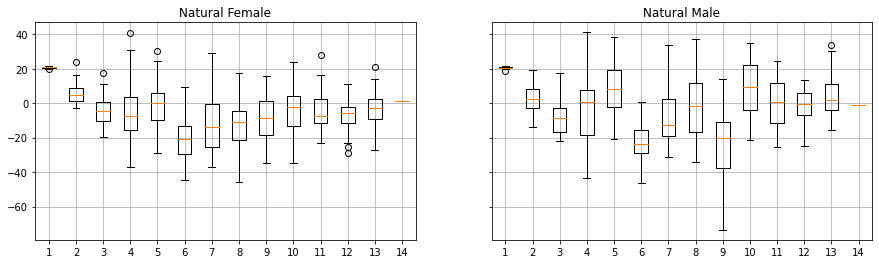

In [96]:
f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()

## Normalisation
On peut voir que nos variables ne sont pas normalisées. Pour améliorer la rapidité de l'entrainement nous allons les amener à la même echelle [0,1]

In [150]:
from sklearn.preprocessing import MinMaxScaler
# Dataset with both classes
df_mfcc = np.append(naf_mfcc_median, nam_mfcc_median, axis=0)

inputs = df_mfcc[:, :13]

# Normalization of the inputs
df_mfcc = np.append(MinMaxScaler().fit_transform(inputs), df_mfcc[:, [13]], axis=1)

df_mfcc = pd.DataFrame(df_mfcc, columns=[*range(1, 14)] + ['class'])

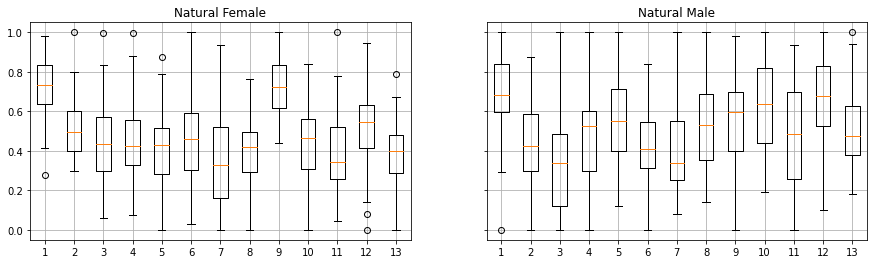

In [152]:
f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(df_mfcc.loc[df_mfcc['class'] == 1].loc[:, df_mfcc.columns != 'class'])
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(df_mfcc.loc[df_mfcc['class'] == -1].loc[:, df_mfcc.columns != 'class'])
ax2.set_title('Natural Male')
ax2.grid()

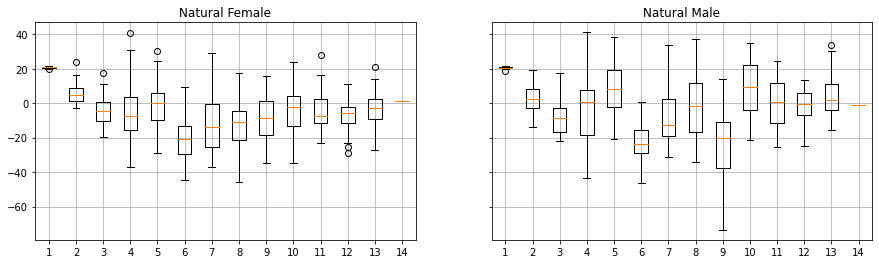

In [99]:
f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()

On a trouvé que les paires de MFCC (8,9), (8,4), (9,4) pourraient être utiles pour la prédiction. Mais pour cette expérience, on peut simplement utiliser l'ensemble complet des MFCC.

# MLP

## Exploring the number of epochs and hyper parameters

Nous faisons un premier entrainement avec des hyper-parametres "standard" pour estimer la complexité du problème

In [100]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [101]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        MSE[i_h, i, :] = nn.fit((df_mfcc[:,0:13], df_mfcc[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


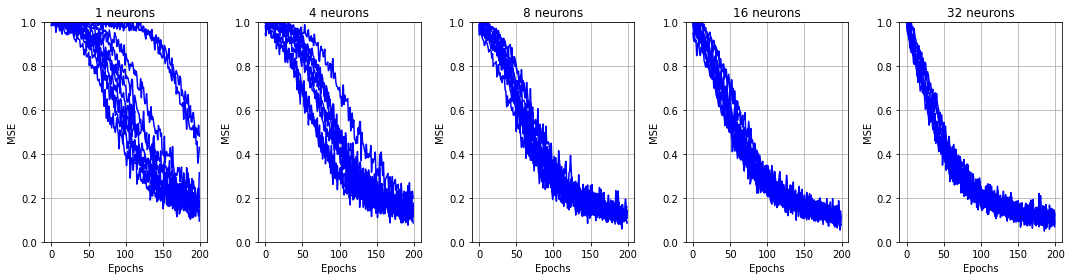

In [102]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

On peut voir que l'erreur ne diminue pas de manière significative après ~150 Epochs peut importe le nombre de neurones dans la couche cachée.
Un learning rate de 0.001 et un momentum de 0.5 donne des résultats qui semblent acceptables. Nous les utiliserons comme base.

## Hyper parameter tuning

In [103]:
K = 5
N_TESTS = 10

# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [104]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            df_mfcc,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


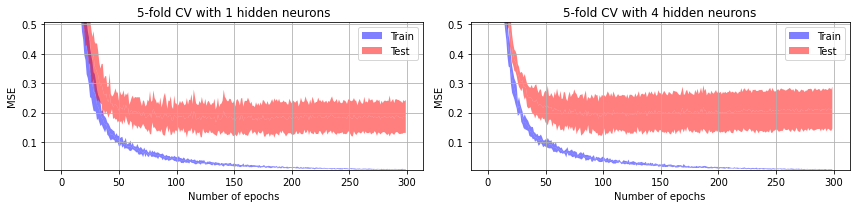

In [121]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()
pl.savefig('../output/xp1/' + 'perf_epoch_' + str(EPOCHS) + '_lr_' + str(LEARNING_RATE) + '_m_'+ str(MOMENTUM) + '.png', dpi=500)

On essaie un grand ensemble d'hyper paramètre

In [122]:
K = 5
N_TESTS = 10

# Hyper parameters...
N_INITS = 10
EPOCHS = 300
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = [0.01, 0.005, 0.001]
MOMENTUM = [0.3, 0.5, 0.7]

MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

data = []

for lr in LEARNING_RATE:
    for mom in MOMENTUM:
        for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
            print('Testing', h, 'neurons...')
            nn = mlp.MLP([13,h,1], 'tanh')
            for i in np.arange(N_TESTS):                                        # looping the tests
                nn.init_weights()                                               # the network has to be reinitialized before each test
                temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                                    df_mfcc,    # but cv.k_fold_cross_validation_per_epoch which
                                                                    k=K,        # returns a value of error per each epoch
                                                                    learning_rate=lr,
                                                                    momentum=mom,
                                                                    epochs=EPOCHS)
                # temp1 and temp2 are the training and test error. One value per epoch
                MSE_train[i_h, :, i] = temp1
                MSE_test[i_h, :, i] = temp2
        MSE_test_mean = np.mean(MSE_test, axis=2)
        for n_i, n in enumerate(N_NEURONS):
            data.append([lr, mom, n, np.min(MSE_test_mean[n_i])])

Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


In [124]:
df_data = pd.DataFrame(data, columns=['learning_rate', 'momentum', 'n_neurons', 'min_MSE'])
print(df_data.sort_values('min_MSE'))

    learning_rate  momentum  n_neurons   min_MSE
21          0.005       0.5          4  0.141545
26          0.005       0.7          4  0.151604
23          0.005       0.5         16  0.156554
7           0.010       0.5          8  0.156803
8           0.010       0.5         16  0.156914
4           0.010       0.3         32  0.157963
12          0.010       0.7          8  0.161200
20          0.005       0.5          1  0.161594
27          0.005       0.7          8  0.162532
5           0.010       0.5          1  0.162635
28          0.005       0.7         16  0.165516
22          0.005       0.5          8  0.166597
2           0.010       0.3          8  0.167374
17          0.005       0.3          8  0.169026
14          0.010       0.7         32  0.169503
43          0.001       0.7         16  0.171338
15          0.005       0.3          1  0.171478
3           0.010       0.3         16  0.171672
44          0.001       0.7         32  0.172353
25          0.005   

La paire d'hyper paramètres (learning rate = 0.005, momentum = 0.5) produit le 1er et le 3e meilleur résultat.

momentum            0.3       0.5       0.7
learning_rate                              
0.001          0.201341  0.199453  0.171338
0.005          0.169026  0.141545  0.151604
0.010          0.157963  0.156803  0.161200


<AxesSubplot:xlabel='momentum', ylabel='learning_rate'>

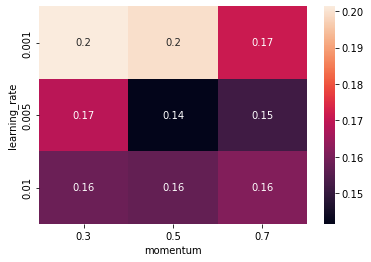

In [131]:
import seaborn as sns

df_wide = df_data.pivot_table( index='learning_rate', columns='momentum', values='min_MSE', aggfunc=min)
print(df_wide)
sns.heatmap(df_wide, annot=True)

Les meilleures hyper paramètres que nous avons trouvé sont donc un learning rate de 0.005, un momentum de 0.5 et 4 neurones dans la couche cachée.

Maintenant nous allons vérifier si 200 epochs est bien le bon nombre d'itération pour ces valeurs.

In [132]:
K = 5
N_TESTS = 10

# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [4]
LEARNING_RATE = 0.005
MOMENTUM = 0.5

MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            df_mfcc,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 4 neurons...


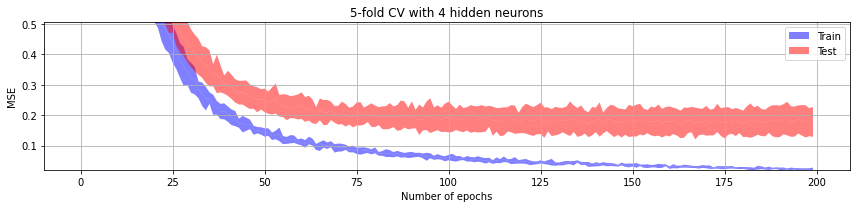

In [133]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()
pl.savefig('../output/xp1/' + 'perf_epoch_' + str(EPOCHS) + '_lr_' + str(LEARNING_RATE) + '_m_'+ str(MOMENTUM) + '.png', dpi=500)

Effectivement on peut voir que le modèle ne gagne plus de performance après ~125 epochs

## Final model

Notre modèle final aura donc 4 neurones, 0.005 de learning rate, un momentum de 0.5 et 125 epochs

In [134]:
nn = mlp.MLP([13,4,1], 'tanh')

EPOCHS = 125
LEARNING_RATE = 0.005
MOMENTUM = 0.5

THRESHOLD = 0.0

In [135]:
def k_fold_cross_validation_without_matrix(mlp, dataset, k=5, learning_rate=0.01, momentum=0.7, epochs=100, threshold=None):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = cv.split_dataset(dataset, k)
    print(parts)
    target_test = []
    output_test = []

    for k_i in np.arange(k):
        mlp.init_weights()

        training_parts = set(np.arange(k))
        training_parts.remove(k_i)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k_i]

        input_data = dataset_train[:,0:mlp.n_inputs]
        output_data = dataset_train[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]
        input_data_test = dataset_test[:,0:mlp.n_inputs]
        output_data_test = dataset_test[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]

        mlp.fit((input_data, output_data),
                learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        MSE_train, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += MSE_train

        MSE_test, temp_out = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += MSE_test
        output_test.append(temp_out)
        target_test.append(output_data_test)

    target_test = np.concatenate(target_test, axis=0)
    output_test = np.concatenate(output_test, axis=0)

    if threshold is None:
        return (MSE_train_mean / k, MSE_test_mean / k)
    else:
        return (MSE_train_mean / k, MSE_test_mean / k, target_test, output_test)

In [136]:
N_SPLITS = 10

MSE_train = np.zeros(N_SPLITS)
MSE_test = np.zeros(N_SPLITS)

targets = []
outputs = []

for d in np.arange(N_SPLITS):
    sys.stdout.write('.')
    temp1, temp2, target, output = k_fold_cross_validation_without_matrix(nn,
                                                              df_mfcc,
                                                              k=K,
                                                              learning_rate=LEARNING_RATE,
                                                              momentum=MOMENTUM,
                                                              epochs=EPOCHS,
                                                              threshold=THRESHOLD)

    MSE_train[d] = temp1
    MSE_test[d] = temp2
    targets.append(target)
    outputs.append(output)

targets = np.concatenate(targets, axis=0)
outputs = np.concatenate(outputs, axis=0)

.[array([[ 0.73382058,  0.53814425,  0.28610502,  0.07971702,  0.32954714,
         0.40637073,  0.68731701,  0.93884946,  0.7433661 ,  0.33220864,
         0.45404498,  0.82163047,  0.47497294, -1.        ],
       [ 0.86224976,  0.58511279,  0.1267223 ,  0.41390102,  0.27394985,
         0.45711865,  0.60492129,  0.38909546,  0.81817423,  0.64988805,
         0.26060071,  0.42883899,  0.01657805,  1.        ],
       [ 0.41418694,  0.47300113,  0.39182155,  0.50243983,  0.97332737,
         0.77398759,  0.14614731,  0.35291407,  0.36148204,  0.66237213,
         0.61760198,  0.11535347,  0.4050472 , -1.        ],
       [ 0.6822971 ,  0.63182932,  0.71645858,  0.07399616,  0.35779508,
         1.        ,  0.31505457,  0.35668991,  0.54634664,  0.39151931,
         1.        ,  0.08100693,  0.35194679,  1.        ],
       [ 0.76079335,  0.48741497,  0.530385  ,  0.33114193,  0.19445409,
         0.46686797,  0.69025415,  0.67129702,  0.7313504 ,  0.28852978,
         0.29745503,  0.

In [137]:
conf_mat = cv.compute_confusion_matrix(targets, outputs, THRESHOLD)

y_pred = [-1 if y[0] < THRESHOLD else 1 for y in outputs.tolist()]
y_true = [-1 if y[0] < THRESHOLD else 1 for y in targets.tolist()]

In [138]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  [0.04792346 0.04471463 0.0387698  0.0397042  0.05326009 0.04568242
 0.0398006  0.04566483 0.05545609 0.03952725]
MSE test:  [0.23904708 0.24598069 0.18331149 0.15302952 0.17032637 0.12311487
 0.14009703 0.21562199 0.19569644 0.24657478]
Confusion matrix:
[[340.  20.]
 [ 27. 333.]]


Calcul des performances...

Accuracy:  0.9347222222222222
F1-Score:  0.9353507565337
Recall 0.9444444444444444


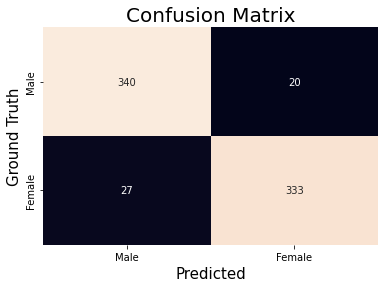

In [159]:
import sklearn.metrics as metrics

# Rows are the actual class and columns are the predicted class
print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
print("F1-Score: ", metrics.f1_score(y_true, y_pred))
print("Recall", metrics.recall_score(y_true, y_pred))

classes = ['Male', 'Female']
ax = sns.heatmap(conf_mat, annot=True, cbar=False, fmt=".3g", xticklabels=classes, yticklabels=classes)
pl.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
pl.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
pl.ylabel('Ground Truth', fontsize = 15) # y-axis label with fontsize 15

pl.show()